<a href="https://colab.research.google.com/github/JoshuaShunk/F1_data/blob/main/F1_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import csv
import requests
from bs4 import BeautifulSoup
from concurrent.futures import ThreadPoolExecutor, as_completed
import re
from datetime import datetime, timedelta
import time
import gc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:


def parse_time(time_str):
    if not time_str or time_str.strip() == '' or any(non_numeric in time_str for non_numeric in ['DNF', 'SHC', 'DSQ', 'DNC', 'OK', 'DNS']):
        return 0
    if ':' in time_str:
        parts = time_str.split(':')
        if len(parts) == 3:
            h, m, s = parts
            total_seconds = int(h) * 3600 + int(m) * 60 + float(s)
        elif len(parts) == 2:
            m, s = parts
            total_seconds = int(m) * 60 + float(s)
    elif '+' in time_str and 'lap' in time_str:
        return time_str
    else:
        total_seconds = float(time_str.replace('+', '').replace('s', ''))
    return total_seconds

def get_race_schedule(year):
    url = f"http://ergast.com/api/f1/{year}.json"
    response = requests.get(url)
    race_schedule = {}
    if response.status_code == 200:
        data = response.json()
        races = data['MRData']['RaceTable']['Races']
        for race in races:
            date = race['date']
            time = race.get('time')
            race_schedule[date] = time
    else:
        print(f"Failed to retrieve data for {year}")
    return race_schedule

def parse_race_numbers(soup):
    race_links = soup.select('a.resultsarchive-filter-item-link')
    race_numbers = []
    for link in race_links:
        href = link.get('href')
        match = re.search(r'/results.html/\d{4}/races/(\d+)/', href)
        if match:
            race_number = match.group(1)
            race_numbers.append(int(race_number))
    return race_numbers

def fetch_race_summary(session, url):
    response = session.get(url)
    if response.status_code != 200:
        return []

    soup = BeautifulSoup(response.content, 'html.parser')
    race_table = soup.find('table', class_='resultsarchive-table')
    if not race_table:
        return []
    race_rows = race_table.find_all('tr')

    races = {}
    for row in race_rows:
        cells = row.find_all('td')
        if len(cells) > 0:
            race_name = cells[1].text.strip().lower().replace(' ', '-')
            laps = cells[4].text.strip().lower()
            if race_name not in races and laps != 'null':
                races[race_name] = laps
    return list(races.keys())

def fetch_race_data(session, race_url, fastest_lap_url, pit_stop_url):
    responses = []
    with ThreadPoolExecutor(max_workers=5) as executor:
        responses = list(executor.map(session.get, [race_url, fastest_lap_url, pit_stop_url]))
    return responses

def geocode_location(location):
    alternate_names = {
        "Melbourne Grand Prix Circuit, Melbourne": "Melbourne, Australia",
        "Melbourne Grand Prix Circuit, Australia": "Melbourne, Australia",
        "Valencia Street Circuit, Spain": "Valencia, Spain",
        "Silverstone Circuit, Great Britain": "Silverstone, UK",
        "Korean International Circuit, South Korea": "Korea International Circuit, South Korea",
        "Hungaroring, Budapest": "Budapest, Hungary",
        "Sochi Autodrom, Sochi": "Sochi, Russia",
        "Circuit de Spa-Francorchamps, Spa-Francorchamps": "Spa-Francorchamps, Belgium",
        "Bahrain International Circuit, Sakhir": "Sakhir, Bahrain",
        "Albert Park Grand Prix Circuit, Melbourne": "Albert Park, Melbourne",
        "Marina Bay Street Circuit, Marina Bay": "Marina Bay, Singapore",
        "Autodromo Enzo e Dino Ferrari, San Marino": "Imola, Italy",
        "Suzuka International Racing Course, Japan": "Suzuka Circuit, Japan",
        "Intercity Istanbul Park, Istanbul": "Istanbul Park, Turkey",
        "Bahrain International Circuit – Outer Track, Sakhir": "Sakhir, Bahrain",
        "Long Beach Street Circuit, United States": "Long Beach, California, USA",
        "Circuit Île Notre-Dame, Canada": "Circuit Gilles Villeneuve, Montreal, Canada",
        "Autódromo Internacional do Rio de Janeiro, Brazil": "Jacarepaguá, Rio de Janeiro, Brazil",
        "Autodromo Dino Ferrari, San Marino": "Imola, Italy",
        "Circuito Permanente del Jarama, Spain": "Jarama, Spain",
        "Caesar's Palace, United States": "Las Vegas, Nevada, USA",
        "Detroit Street Circuit, United States": "Detroit, Michigan, USA",
        "Brands Hatch Circuit, Great Britain": "Brands Hatch, UK",
        "Adelaide Street Circuit, Australia": "Adelaide, Australia",
        "Phoenix Street Circuit, United States": "Phoenix, Arizona, USA",
        "Donington Park, Great Britain": "Donington Park, UK",
        "TI Circuit Aida, Japan": "Okayama International Circuit, Japan",
        "Circuit de Pedralbes, Spain": "Barcelona, Spain",
        "Autódromo 17 de Octubre, Argentina": "Autódromo Juan y Oscar Gálvez, Buenos Aires, Argentina",
        "Aintree Racecourse, Great Britain": "Aintree, UK",
        "Pescara Circuit, Italy": "Pescara, Italy",
        "Circuit da Boavista, Portugal": "Porto, Portugal",
        "Ain-Diab Circuit, Morocco": "Casablanca, Morocco",
        "Riverside International Raceway, United States": "Riverside, California, USA",
        "Zeltweg Airfield, Austria": "Zeltweg, Austria",
        "Complexe Européen de Nivelles-Baulers, Belgium": "Nivelles, Belgium"
    }

    location_to_search = alternate_names.get(location, location)

    base_url = "https://nominatim.openstreetmap.org/search"
    params = {
        "q": location_to_search,
        "format": "json",
        "limit": 1
    }
    headers = {
        "User-Agent": "notmywebsite.com (thisismyemail@gmail.com)"
    }
    response = requests.get(base_url, params=params, headers=headers)
    if response.status_code == 200:
        data = response.json()
        if data:
            lat = data[0]["lat"]
            lon = data[0]["lon"]
            return lat, lon
        else:
            print(f"No coordinates found for location: {location}")
            return None, None
    else:
        print(f"Failed to fetch coordinates: {response.status_code}")
        print(f"Response content: {response.text}")
        return None, None

def fetch_historical_weather_data(lat, lon, start_time, end_time=None):
    base_url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start_time.strftime("%Y-%m-%d") if start_time else end_time.strftime("%Y-%m-%d"),
        "end_date": end_time.strftime("%Y-%m-%d") if end_time else start_time.strftime("%Y-%m-%d"),
        "hourly": ["temperature_2m", "precipitation"]
    }
    if start_time and end_time:
        params["start_time"] = start_time.strftime("%H:%M")
        params["end_time"] = end_time.strftime("%H:%M")
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to fetch weather data: {response.status_code}")
        return None

def parse_race_results_with_weather(race_response, fastest_lap_response, pit_stop_response, race_name, race_title, year, location, race_date, race_time):
    race_date = datetime.strptime(race_date, "%d %b %Y").strftime("%Y-%m-%d")
    if race_time:
        start_time = datetime.strptime(f"{race_date} {race_time.rstrip('Z')}", "%Y-%m-%d %H:%M:%S")
        end_time = start_time + timedelta(hours=2)
    else:
        print(f"No start time found for race {race_name} on date {race_date}")
        start_time = datetime.strptime(race_date, "%Y-%m-%d")
        end_time = None

    race_results = parse_race_results(race_response, fastest_lap_response, pit_stop_response, race_name, race_title, year, race_date, start_time, end_time)
    lat, lon = geocode_location(location)
    if lat and lon:
        weather_data = fetch_historical_weather_data(lat, lon, start_time, end_time)
        if weather_data and "hourly" in weather_data:
            hourly_data = weather_data["hourly"]
            temperatures = hourly_data["temperature_2m"]
            precipitations = hourly_data["precipitation"]
            if temperatures and precipitations:
                avg_temp = sum(temperatures) / len(temperatures)
                total_precipitation = sum(precipitations)
                for result in race_results:
                    result["weather_temp_c"] = avg_temp
                    result["weather_precipitation_mm"] = total_precipitation
            else:
                print(f"No temperature or precipitation data available for {location} on {race_date}")
                for result in race_results:
                    result["weather_temp_c"] = "N/A"
                    result["weather_precipitation_mm"] = "N/A"
        else:
            print(f"No weather data found for coordinates {lat},{lon} on {race_date}")
            for result in race_results:
                result["weather_temp_c"] = "N/A"
                result["weather_precipitation_mm"] = "N/A"
    else:
        for result in race_results:
            result["weather_temp_c"] = "N/A"
            result["weather_precipitation_mm"] = "N/A"
    return race_results

def parse_race_results(race_response, fastest_lap_response, pit_stop_response, race_name, race_title, year, date, start_time, end_time):
    race_results = []
    race_soup = BeautifulSoup(race_response.content, 'html.parser')
    results_table = race_soup.find('table', class_='resultsarchive-table')
    if not results_table:
        return race_results
    rows = results_table.find_all('tr')

    header_row = rows[0].find_all('th')
    headers = [header.text.strip().lower() for header in header_row]

    pos_idx = headers.index('pos')
    driver_idx = headers.index('driver')
    laps_idx = headers.index('laps')
    time_idx = headers.index('time/retired')
    points_idx = headers.index('pts')
    car_idx = headers.index('car') if 'car' in headers else None

    fastest_laps = {}
    if fastest_lap_response.status_code == 200:
        fastest_lap_soup = BeautifulSoup(fastest_lap_response.content, 'html.parser')
        fastest_lap_table = fastest_lap_soup.find('table', class_='resultsarchive-table')
        if fastest_lap_table:
            fastest_lap_rows = fastest_lap_table.find_all('tr')
            fl_header_row = fastest_lap_rows[0].find_all('th')
            fl_headers = [header.text.strip().lower() for header in fl_header_row]
            if 'driver' in fl_headers and 'time' in fl_headers:
                fl_driver_idx = fl_headers.index('driver')
                fl_time_idx = fl_headers.index('time')
                fl_speed_idx = fl_headers.index('avg speed') if 'avg speed' in fl_headers else None

                for row in fastest_lap_rows[1:]:
                    cells = row.find_all('td')
                    if len(cells) > 0:
                        driver_abbr = cells[fl_driver_idx].text.strip()
                        fastest_lap_time = cells[fl_time_idx].text.strip()
                        avg_speed = cells[fl_speed_idx].text.strip() if fl_speed_idx is not None else 'N/A'
                        fastest_laps[driver_abbr] = {
                            'fastest_lap_time': fastest_lap_time,
                            'average_speed': avg_speed
                        }

    pit_stops = {}
    if pit_stop_response.status_code == 200:
        pit_stop_soup = BeautifulSoup(pit_stop_response.content, 'html.parser')
        pit_stop_table = pit_stop_soup.find('table', class_='resultsarchive-table')
        if pit_stop_table:
            pit_stop_rows = pit_stop_table.find_all('tr')
            ps_header_row = pit_stop_rows[0].find_all('th')
            ps_headers = [header.text.strip().lower() for header in ps_header_row]
            if 'driver' in ps_headers and 'lap' in ps_headers and 'time' in ps_headers:
                ps_driver_idx = ps_headers.index('driver')
                ps_lap_idx = ps_headers.index('lap')
                ps_time_idx = ps_headers.index('time')

                for row in pit_stop_rows[1:]:
                    cells = row.find_all('td')
                    if len(cells) > 0:
                        driver_abbr = cells[ps_driver_idx].text.strip()
                        lap = cells[ps_lap_idx].text.strip()
                        time = cells[ps_time_idx].text.strip()
                        if driver_abbr not in pit_stops:
                            pit_stops[driver_abbr] = []
                        pit_stops[driver_abbr].append({'lap': lap, 'time': time})

    leader_time = None
    for row in rows[1:]:
        cells = row.find_all('td')
        if len(cells) > 0:
            position = cells[pos_idx].text.strip()
            driver = cells[driver_idx].text.strip().replace('\n', ' ')
            laps = cells[laps_idx].text.strip()
            time = cells[time_idx].text.strip()
            points = cells[points_idx].text.strip()
            car = cells[car_idx].text.strip() if car_idx is not None else 'N/A'
            driver_abbr = cells[driver_idx].text.strip()

            if position == '1':
                leader_time = parse_time(time)
                total_time = time
            else:
                if any(non_numeric in time for non_numeric in ['DNF', 'SHC', 'DSQ', 'DNC', 'OK', 'DNS']):
                    total_time = time
                elif 'lap' in time:
                    total_time = time
                else:
                    if leader_time is not None:
                        time_in_seconds = parse_time(time)
                        total_time_in_seconds = leader_time + time_in_seconds
                        total_time = f'{int(total_time_in_seconds // 3600)}:{int((total_time_in_seconds % 3600) // 60)}:{total_time_in_seconds % 60:.3f}'
                    else:
                        total_time = 'DNF'

            race_result = {
                'position': position,
                'driver': driver,
                'car': car,
                'laps': laps,
                'total_time': total_time,
                'points': points,
                'race': race_name,
                'race_title': race_title,
                'year': year,
                'date': date,
                'start_time': start_time.strftime("%H:%M") if end_time else 'N/A',
                'fastest_lap_time': fastest_laps.get(driver_abbr, {}).get('fastest_lap_time', 'DNF'),
                'average_speed': fastest_laps.get(driver_abbr, {}).get('average_speed', 'N/A'),
                'total_pits': len(pit_stops.get(driver_abbr, [])) if driver_abbr in pit_stops else 'N/A',
                'total_pit_time': sum([parse_time(pit['time']) for pit in pit_stops.get(driver_abbr, []) if pit['time']]) if driver_abbr in pit_stops else 'N/A'
            }

            for i in range(6):
                if i < len(pit_stops.get(driver_abbr, [])):
                    race_result[f'pit_{i+1}'] = pit_stops[driver_abbr][i]['time']
                    race_result[f'lap_pit_{i+1}'] = pit_stops[driver_abbr][i]['lap']
                else:
                    race_result[f'pit_{i+1}'] = 'N/A'
                    race_result[f'lap_pit_{i+1}'] = 'N/A'

            race_results.append(race_result)

    return race_results

def save_to_csv(data, filename):
    import os

    # Save file to Google Drive
    drive_path = '/content/drive/MyDrive/F1 Data'  # Modify this path as necessary
    file_path = os.path.join(drive_path, filename)

    fieldnames = [
        'position', 'driver', 'car', 'laps', 'total_time', 'points',
        'race', 'race_title', 'year', 'date', 'start_time',
        'fastest_lap_time', 'average_speed', 'total_pits', 'total_pit_time',
        'weather_temp_c', 'weather_precipitation_mm'
    ]
    for i in range(1, 7):
        fieldnames.append(f'pit_{i}')
        fieldnames.append(f'lap_pit_{i}')

    with open(file_path, 'w', newline='') as output_file:
        dict_writer = csv.DictWriter(output_file, fieldnames=fieldnames)
        dict_writer.writeheader()
        dict_writer.writerows(data)

    print(f"Data saved to {file_path}")






In [ ]:
def main():
    years = range(1950, 2023)
    all_race_results = []
    session = requests.Session()

    for year in years:
        print(f"Fetching races for year {year}...")
        url = f'https://www.formula1.com/en/results.html/{year}/races.html'
        response = session.get(url)
        if response.status_code != 200:
            continue
        soup = BeautifulSoup(response.content, 'html.parser')
        races = fetch_race_summary(session, url)

        race_numbers = parse_race_numbers(soup)
        race_schedule = get_race_schedule(year)

        with ThreadPoolExecutor(max_workers=5) as executor:
            futures = []
            for i, race in enumerate(races):
                race_number = race_numbers[i]
                race_url = f'https://www.formula1.com/en/results.html/{year}/races/{race_number}/{race}/race-result.html'
                fastest_lap_url = f'https://www.formula1.com/en/results.html/{year}/races/{race_number}/{race}/fastest-laps.html'
                pit_stop_url = f'https://www.formula1.com/en/results.html/{year}/races/{race_number}/{race}/pit-stop-summary.html'

                race_soup = BeautifulSoup(session.get(race_url).content, 'html.parser')
                race_title = race_soup.find('h1', class_='ResultsArchiveTitle').text.strip()
                race_date = race_soup.find('span', class_='full-date').text.strip()
                location = race_soup.find('span', class_='circuit-info').text.strip()
                start_time = race_schedule.get(datetime.strptime(race_date, "%d %b %Y").strftime("%Y-%m-%d"))

                print(f"Fetching data for race: {race} with title {race_title} on date: {race_date} at location: {location}...")
                futures.append(executor.submit(parse_race_results_with_weather, session.get(race_url), session.get(fastest_lap_url), session.get(pit_stop_url), race, race_title, year, location, race_date, start_time))

            for future in as_completed(futures):
                race_results = future.result()
                all_race_results.extend(race_results)

                # Introducing a small delay to manage resource usage better
                time.sleep(1)

                # Cleanup to free memory
                gc.collect()

    save_to_csv(all_race_results, 'RAPID_with_weather.csv')
    print("All race data with weather has been saved to 'RAPID_with_weather.csv'")

if __name__ == "__main__":
    main()


Fetching races for year 1950...
Fetching data for race: great-britain with title 1950 British Grand Prix
         - RACE RESULT on date: 13 May 1950 at location: Silverstone Circuit, Great Britain...
No start time found for race great-britain on date 1950-05-13
Fetching data for race: monaco with title 1950 Monaco Grand Prix
         - RACE RESULT on date: 21 May 1950 at location: Circuit de Monaco, Monaco...
No start time found for race monaco on date 1950-05-21
Fetching data for race: indianapolis-500 with title 1950 Indianapolis 500
         - RACE RESULT on date: 30 May 1950 at location: Indianapolis Motor Speedway, United States...
No start time found for race indianapolis-500 on date 1950-05-30
Fetching data for race: switzerland with title 1950 Swiss Grand Prix
         - RACE RESULT on date: 04 Jun 1950 at location: Bremgarten, Switzerland...
No start time found for race switzerland on date 1950-06-04
Fetching data for race: belgium with title 1950 Belgian Grand Prix
         -

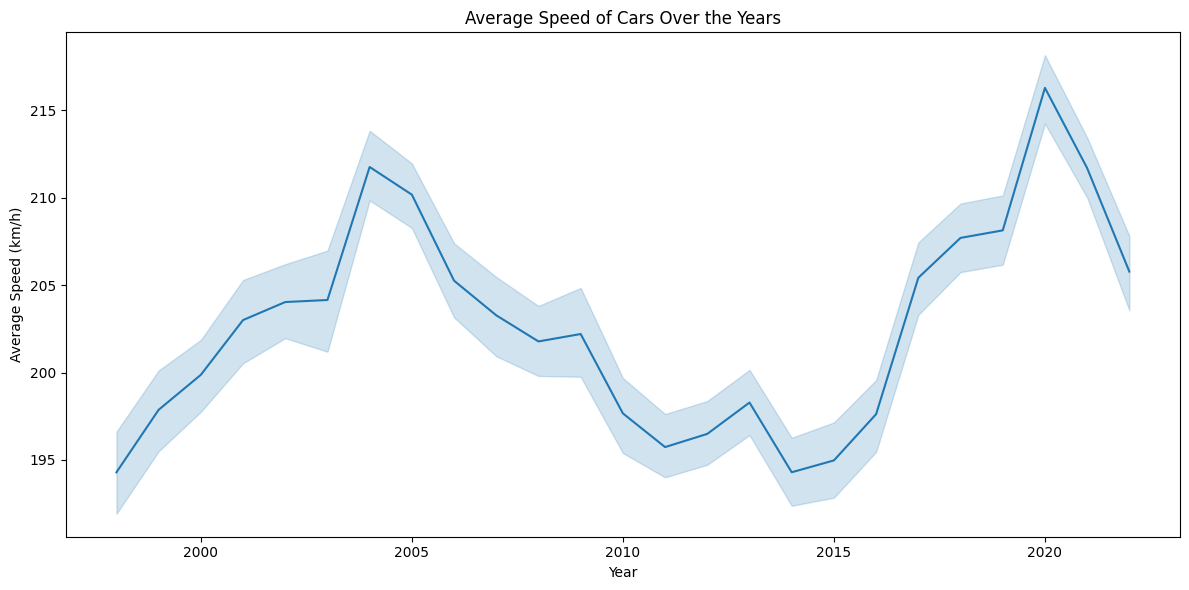

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the CSV file
file_path = '/content/drive/MyDrive/F1 Data/RAPID_with_weather.csv'
data = pd.read_csv(file_path)

# Plot Average Speed Over the Years for the years where speed is available
plt.figure(figsize=(12, 6))
speed_data = data.dropna(subset=['average_speed'])
sns.lineplot(x='year', y='average_speed', data=speed_data)
plt.title('Average Speed of Cars Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Speed (km/h)')
plt.tight_layout()
plt.show()


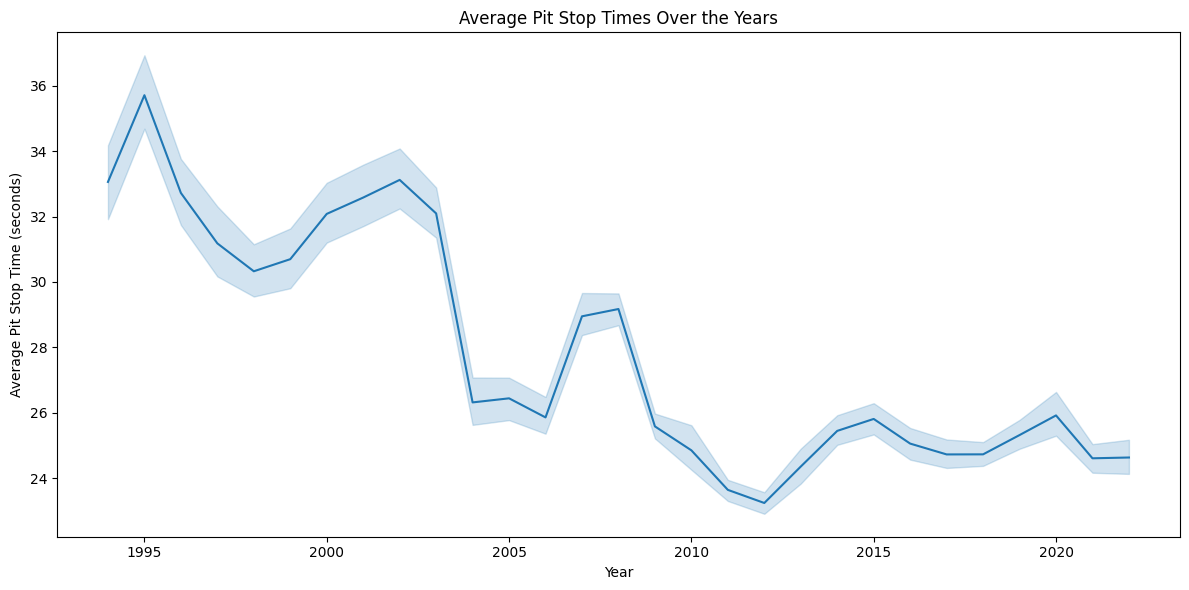

In [ ]:
# Calculate average pit stop time per race by dividing total pit time by total pits
data['average_pit_time'] = data['total_pit_time'] / data['total_pits']

# Remove outliers by setting a threshold for average pit time (e.g., 60 seconds)
filtered_data = data[data['average_pit_time'] < 100]

# Plot Average Pit Stop Times Over the Years excluding outliers
plt.figure(figsize=(12, 6))
average_pit_time_filtered = filtered_data.dropna(subset=['average_pit_time'])
sns.lineplot(x='year', y='average_pit_time', data=average_pit_time_filtered, estimator='mean')
plt.title('Average Pit Stop Times Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Pit Stop Time (seconds)')
plt.tight_layout()
plt.show()

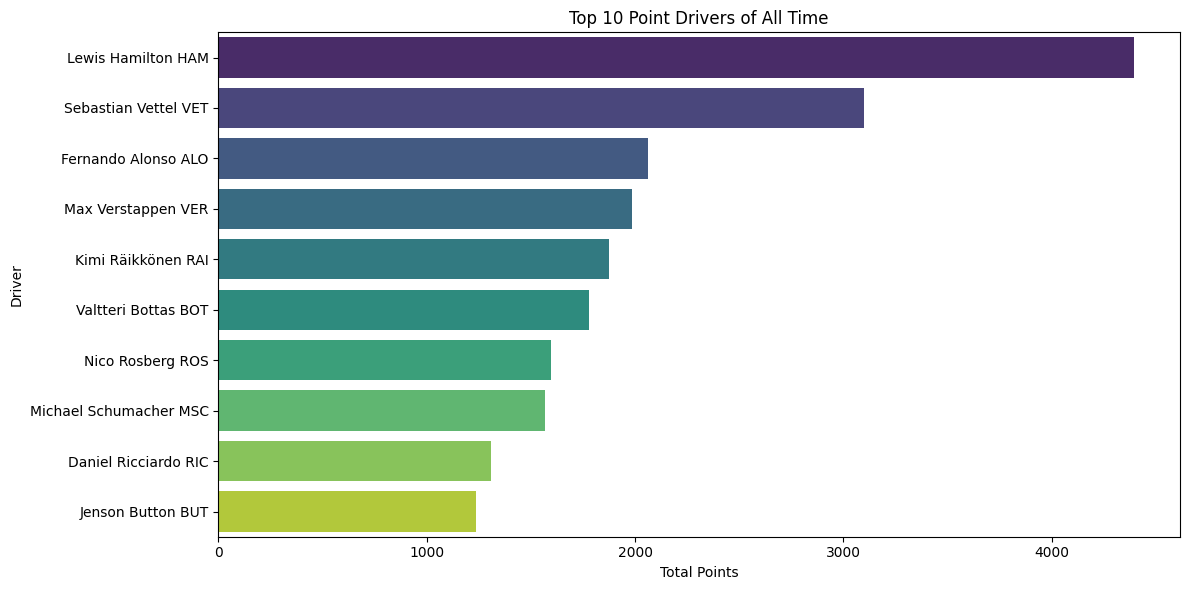

In [ ]:
# Calculate the total points for each driver
top_drivers = data.groupby('driver')['points'].sum().reset_index()

# Sort the drivers by points in descending order and select the top 10
top_10_drivers = top_drivers.sort_values(by='points', ascending=False).head(10)

# Plot the top 10 point drivers of all time
plt.figure(figsize=(12, 6))
sns.barplot(x='points', y='driver', data=top_10_drivers, hue='driver', palette='viridis', dodge=False, legend=False)
plt.title('Top 10 Point Drivers of All Time')
plt.xlabel('Total Points')
plt.ylabel('Driver')
plt.tight_layout()
plt.show()

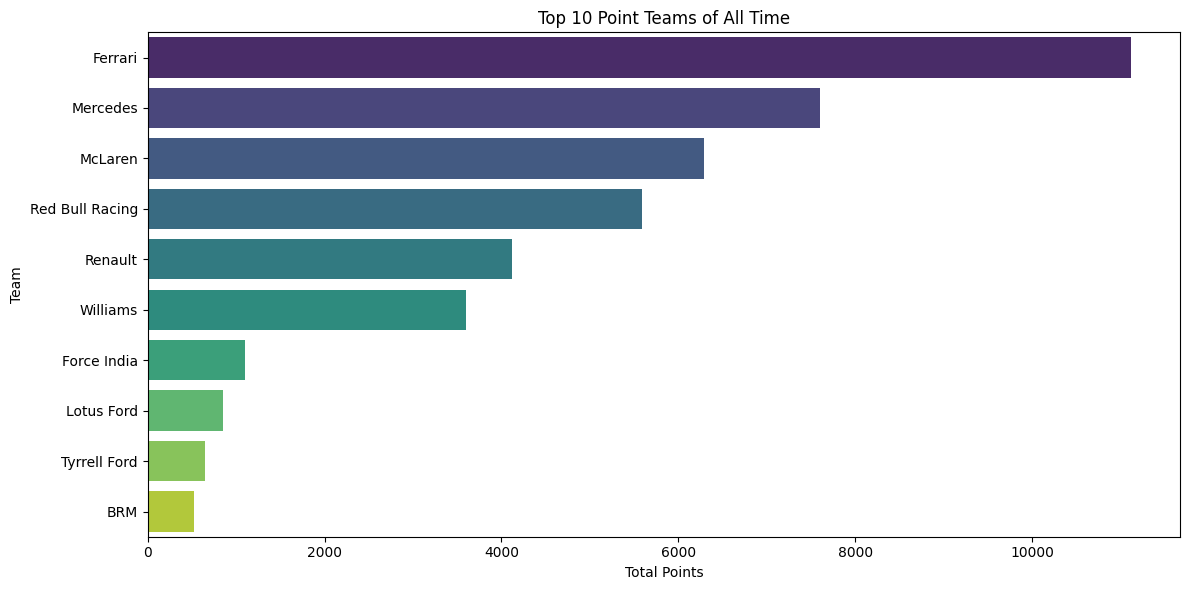

In [ ]:
# Handle missing or non-string values in the 'car' column
data['car'] = data['car'].fillna('Unknown').astype(str)

# Clean up team names to group them correctly
def clean_team_name(team):
    if 'Red Bull Racing' in team:
        return 'Red Bull Racing'
    elif 'McLaren' in team:
        return 'McLaren'
    elif 'Williams' in team:
        return 'Williams'
    elif 'Force India' in team:
        return 'Force India'
    elif 'Mercedes' in team:
        return 'Mercedes'
    elif 'Ferrari' in team:
        return 'Ferrari'
    elif 'Renault' in team:
        return 'Renault'
    else:
        return team

data['cleaned_team'] = data['car'].apply(clean_team_name)

# Calculate the total points for each cleaned team
top_teams = data.groupby('cleaned_team')['points'].sum().reset_index()

# Sort the teams by points in descending order and select the top 10
top_10_teams = top_teams.sort_values(by='points', ascending=False).head(10)

# Plot the top 10 point teams of all time
plt.figure(figsize=(12, 6))
sns.barplot(x='points', y='cleaned_team', data=top_10_teams, hue='cleaned_team', palette='viridis', dodge=False, legend=False)
plt.title('Top 10 Point Teams of All Time')
plt.xlabel('Total Points')
plt.ylabel('Team')
plt.tight_layout()
plt.show()

<ipython-input-8-d7ff2d7ebd37>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='rain', y='average_speed', data=rain_impact, palette='viridis')


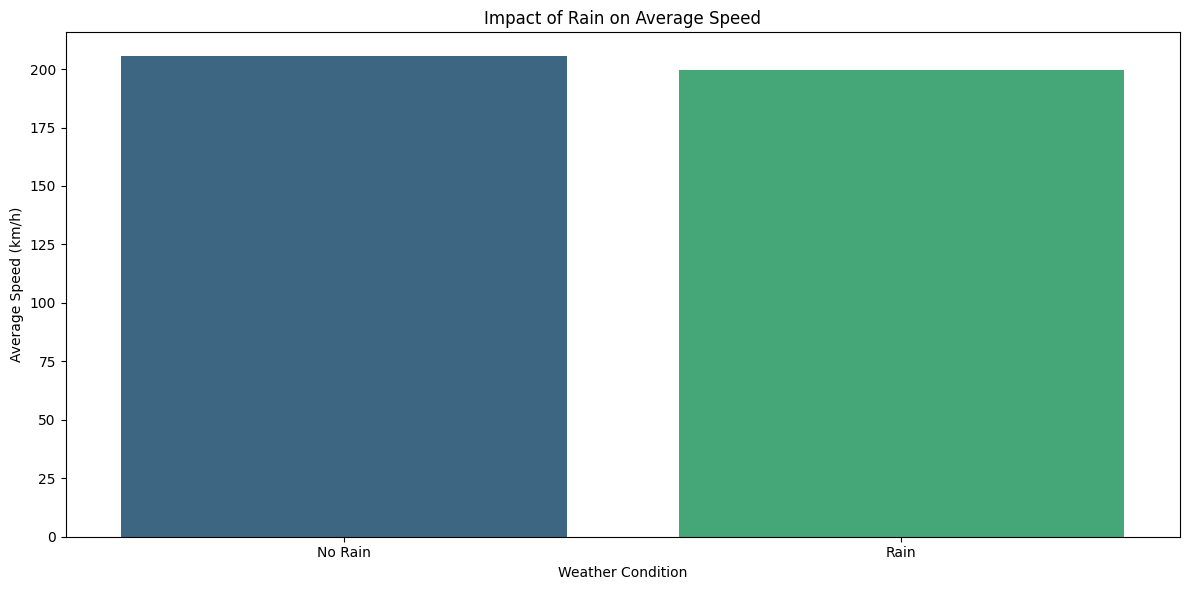

In [ ]:
# Create a new column to categorize races based on precipitation
data['rain'] = data['weather_precipitation_mm'].apply(lambda x: 'Rain' if x > 0 else 'No Rain')

# Calculate average speed under different weather conditions (rain vs no rain)
rain_impact = data.groupby('rain')['average_speed'].mean().reset_index()

# Plot average speed under different weather conditions (rain vs no rain)
plt.figure(figsize=(12, 6))
sns.barplot(x='rain', y='average_speed', data=rain_impact, palette='viridis')
plt.title('Impact of Rain on Average Speed')
plt.xlabel('Weather Condition')
plt.ylabel('Average Speed (km/h)')
plt.tight_layout()
plt.show()

In [ ]:
# Plot the distribution of average speeds in rainy and dry conditions
plt.figure(figsize=(12, 6))
sns.histplot(speed_rain, kde=True, label='Rain', color='blue')
sns.histplot(speed_no_rain, kde=True, label='No Rain', color='orange')
plt.title('Distribution of Average Speeds in Rainy and Dry Conditions')
plt.xlabel('Average Speed (km/h)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'speed_rain' is not defined

<Figure size 1200x600 with 0 Axes>

In [ ]:
# Create a new column to categorize races based on precipitation
data['rain'] = data['weather_precipitation_mm'].apply(lambda x: 'Rain' if x > 0 else 'No Rain')

# Separate the speeds into two groups: rain and no rain
speed_rain = data[data['rain'] == 'Rain']['average_speed'].dropna()
speed_no_rain = data[data['rain'] == 'No Rain']['average_speed'].dropna()

def robust_ptest(trials, sample_size):
    phenomenon_occurs = 0
    magdiffs = []
    observed_diff = abs(speed_rain.mean() - speed_no_rain.mean())

    for i in range(trials):
        sample_rain = speed_rain.sample(sample_size, replace=True)
        sample_no_rain = speed_no_rain.sample(sample_size, replace=True)

        mean_rain = sample_rain.mean()
        mean_no_rain = sample_no_rain.mean()

        abs_diff = abs(mean_rain - mean_no_rain)
        magdiffs.append(abs_diff)

        if abs_diff >= observed_diff:
            phenomenon_occurs += 1

    return magdiffs, phenomenon_occurs / trials

# Run the robust ptest method
magdiffs_robust, pval_robust = robust_ptest(100000, 100)
print('Robust Bootstrapped p-value:', pval_robust)


Robust Bootstrapped p-value: 0.49869


In [ ]:
import numpy as np

In [ ]:
# Create a new column to categorize races based on precipitation
data['rain'] = data['weather_precipitation_mm'].apply(lambda x: 'Rain' if x > 0 else 'No Rain')

# Separate the speeds into two groups: rain and no rain
speed_rain = data[data['rain'] == 'Rain']['average_speed'].dropna()
speed_no_rain = data[data['rain'] == 'No Rain']['average_speed'].dropna()

# Remove outliers by considering speeds within 1.5*IQR of the 25th and 75th percentiles
Q1_rain = speed_rain.quantile(0.25)
Q3_rain = speed_rain.quantile(0.75)
IQR_rain = Q3_rain - Q1_rain
filtered_rain = speed_rain[(speed_rain >= Q1_rain - 1.5 * IQR_rain) & (speed_rain <= Q3_rain + 1.5 * IQR_rain)]

Q1_no_rain = speed_no_rain.quantile(0.25)
Q3_no_rain = speed_no_rain.quantile(0.75)
IQR_no_rain = Q3_no_rain - Q1_no_rain
filtered_no_rain = speed_no_rain[(speed_no_rain >= Q1_no_rain - 1.5 * IQR_no_rain) & (speed_no_rain <= Q3_no_rain + 1.5 * IQR_no_rain)]

def permutation_test(data1, data2, num_permutations=100000):
    combined = np.concatenate([data1, data2])
    observed_diff = abs(data1.mean() - data2.mean())
    count = 0

    for _ in range(num_permutations):
        np.random.shuffle(combined)
        new_data1 = combined[:len(data1)]
        new_data2 = combined[len(data1):]
        new_diff = abs(new_data1.mean() - new_data2.mean())
        if new_diff >= observed_diff:
            count += 1

    return count / num_permutations

# Run permutation test on filtered data
perm_p_value = permutation_test(filtered_rain, filtered_no_rain, num_permutations=100000)
print('Permutation Test p-value:', perm_p_value)

Permutation Test p-value: 0.0


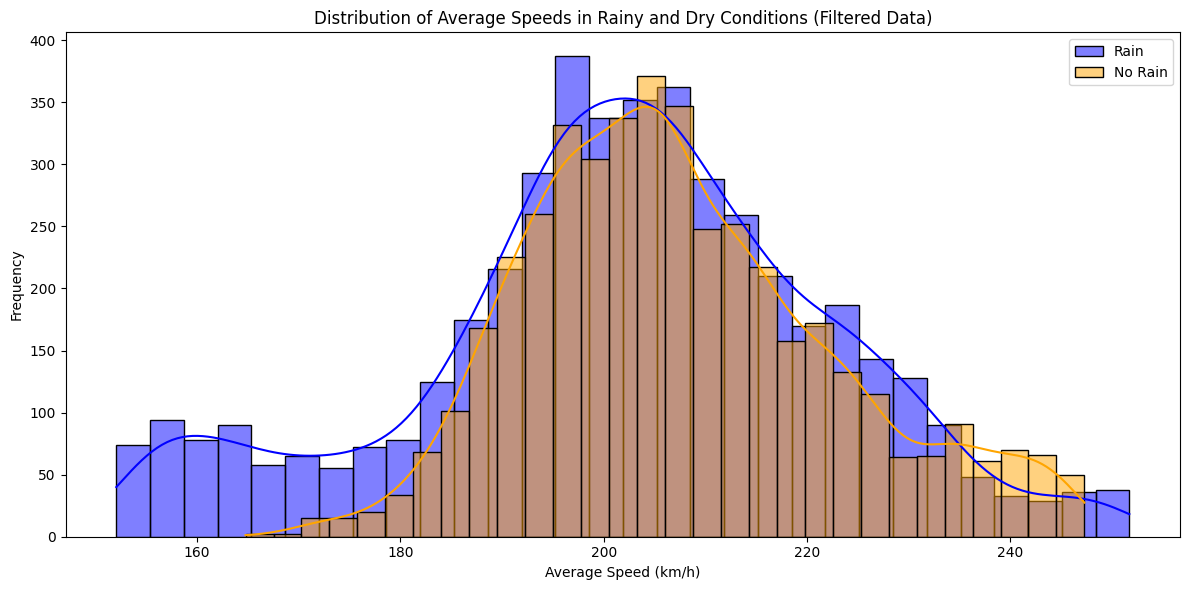

In [ ]:
# Plot the distribution of average speeds in rainy and dry conditions
plt.figure(figsize=(12, 6))
sns.histplot(filtered_rain, kde=True, label='Rain', color='blue', bins=30)
sns.histplot(filtered_no_rain, kde=True, label='No Rain', color='orange', bins=30)
plt.title('Distribution of Average Speeds in Rainy and Dry Conditions (Filtered Data)')
plt.xlabel('Average Speed (km/h)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

# Select relevant columns
relevant_columns = ['race', 'weather_temp_c', 'weather_precipitation_mm', 'average_speed',
                    'pit_1', 'lap_pit_1', 'pit_2', 'lap_pit_2', 'pit_3', 'lap_pit_3',
                    'pit_4', 'lap_pit_4', 'pit_5', 'lap_pit_5', 'pit_6', 'lap_pit_6']
data = data[relevant_columns]

# Handle missing values by imputing them
# For numerical columns, we'll use mean imputation, and for categorical, we'll use the most frequent value
numerical_features = ['weather_temp_c', 'weather_precipitation_mm']
categorical_features = ['race']

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numerical_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ])

# Prepare the features (X) and target (y) for average speed prediction
data_speed = data.dropna(subset=['average_speed'])
X_speed = data_speed.drop(columns=['average_speed', 'pit_1', 'lap_pit_1', 'pit_2', 'lap_pit_2',
                                   'pit_3', 'lap_pit_3', 'pit_4', 'lap_pit_4', 'pit_5', 'lap_pit_5',
                                   'pit_6', 'lap_pit_6'])
y_speed = data_speed['average_speed']

# Split the data into training and testing sets for average speed
X_train_speed, X_test_speed, y_train_speed, y_test_speed = train_test_split(X_speed, y_speed, test_size=0.2, random_state=42)

# Create the pipeline for average speed prediction
speed_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train the speed prediction model
speed_pipeline.fit(X_train_speed, y_train_speed)

# Evaluate the model on the test set
speed_score = speed_pipeline.score(X_test_speed, y_test_speed)
print(f"Average Speed Prediction Model R^2 Score: {speed_score}")

# Prepare the features (X) and target (y) for pit stop prediction
X_pit = data.drop(columns=['average_speed'])
pit_columns = ['lap_pit_1', 'lap_pit_2', 'lap_pit_3', 'lap_pit_4', 'lap_pit_5', 'lap_pit_6']
y_pit = data[pit_columns]

# Handle missing values for the target variables by filling them with a placeholder value (e.g., -1)
y_pit = y_pit.fillna(-1)

# Split the data into training and testing sets for pit stop prediction
X_train_pit, X_test_pit, y_train_pit, y_test_pit = train_test_split(X_pit, y_pit, test_size=0.2, random_state=42)

# Create the pipeline for pit stop prediction using Random Forest
pit_pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42)))
])

# Train the Random Forest model for pit stop prediction
pit_pipeline_rf.fit(X_train_pit, y_train_pit)

# Evaluate the Random Forest model on the test set
pit_score_rf = pit_pipeline_rf.score(X_test_pit, y_test_pit)
print(f"Pit Stop Prediction Model R^2 Score: {pit_score_rf}")




Average Speed Prediction Model R^2 Score: 0.3459768762311688
Pit Stop Prediction Model R^2 Score: 0.3468951035356138


In [ ]:
# Function to make predictions
def make_predictions(race, weather_temp_c, weather_precipitation_mm):
    input_data = pd.DataFrame({
        'race': [race],
        'weather_temp_c': [weather_temp_c],
        'weather_precipitation_mm': [weather_precipitation_mm]
    })

    # Predict average speed
    avg_speed = speed_pipeline.predict(input_data)[0]

    # Predict pit stops
    pit_stops = pit_pipeline_rf.predict(input_data)
    pit_stops = [int(pit) for pit in pit_stops[0] if pit > 0]
    pit_stops.sort()

    return avg_speed, pit_stops

# Example prediction
race = 'monaco'
weather_temp_c = 20.0
weather_precipitation_mm = 0.0

avg_speed, pit_stops = make_predictions(race, weather_temp_c, weather_precipitation_mm)
print(f"Predicted Average Speed: {avg_speed}")
print(f"Predicted Pit Stops: {pit_stops}")

Predicted Average Speed: 184.60813427313585
Predicted Pit Stops: [0, 15, 32]
